2. Test Driven Development

First, we'll take the code we used to access the API and build an AlphaVantageAPI class. This will allow us to reuse our code. Second, we'll create a SQLRepository class that will help us load our stock data into a SQLite database and then extract it for later use. Additionally, we'll build this code using a technique called test driven development, where we'll use assert statements to make sure everything is working properly. That way, we'll avoid issues later when we build our application.

%load_ext autoreload
%load_ext sql
%autoreload 2

import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
from config import settings

In the data module, create a class definition for AlphaVantageAPI. For now, making sure that it has an __init__ method that attaches your API key as the attribute __api_key. Once you're done, import the class below and create an instance of it called av.

In [3]:
# Import `AlphaVantageAPI`
from data import AlphaVantageAPI

# Create instance of `AlphaVantageAPI` class
av = AlphaVantageAPI()

print("av type:", type(av))

av type: <class 'data.AlphaVantageAPI'>


Create a get_daily method for your AlphaVantageAPI class. Once you're done, use the cell below to fetch the stock data

In [7]:
# Define Suzlon ticker symbol
ticker = "EQTY"

# Use your `av` object to get daily data
df_equity = av.get_daily(ticker=ticker)

print("df_equity type:", type(df_equity))
print("df_equity shape:", df_equity.shape)
df_equity.head()

df_equity type: <class 'pandas.core.frame.DataFrame'>
df_equity shape: (53, 5)


,open,high,low,close,volume
date,,,,,
2023-02-28,16.8811,16.9000,16.8300,16.8800,8621.0
2023-02-27,16.8900,16.9781,16.8200,16.8500,27415.0
2023-02-24,16.7900,16.8260,16.6700,16.8063,20330.0
2023-02-23,17.0700,17.0800,16.8700,17.0000,44770.0
2023-02-22,17.0400,17.0700,16.9301,17.0100,184434.0


In [34]:
# Does `get_daily` return a DataFrame?
assert isinstance(df_equity, pd.DataFrame)
# Does DataFrame have 5 columns?
assert df_equity.shape[1] == 5

# Does DataFrame have a DatetimeIndex?

assert isinstance(df_equity.index, pd.DatetimeIndex)
# Is the index name "date"?
assert df_equity.index.name == "date"

In [35]:
# Does DataFrame have correct column names?
assert df_equity.columns.to_list() == ['open', 'high', 'low', 'close', 'volume']
# Are columns correct data type?
assert all(df_equity.dtypes == float)

2.2 SQL Repository Class

It wouldn't be efficient if our application needed to get data from the AlphaVantage API every time we wanted to explore our data or build a model, so we'll need to store our data in a database. Because our data is highly structured (each DataFrame we extract from AlphaVantage is always going to have the same five columns), it makes sense to use a SQL database.

We'll use SQLite for our database. For consistency, this database will always have the same name, which we've stored in our .env file.

Connect to the database whose name is stored in the .env file for this project. Be sure to set the check_same_thread argument to False. Assign the connection to the variable connection.

In [36]:
settings.db_name

'stocks.sqlite'

In [37]:
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False )

print("connection type:", type(connection))

connection type: <class 'sqlite3.Connection'>


We've got a connection, and now we need to start building the class that will handle all our transactions with the database. With this class, though, we're going to create our tests before writing the class definition.

Write two tests for the SQLRepository class


In [38]:
# Import class definition
from data import SQLRepository

# Create instance of class
repo = SQLRepository(connection=connection)

# Does `repo` have a "connection" attribute?
hasattr(repo, "connection")

# Is the "connection" attribute a SQLite `Connection`?
assert isinstance(repo.connection, sqlite3.Connection)

Create a definition for your SQLRepository class. For now, just complete the __init__ method. Once you're done, use the code you wrote in the previous task to test it.

The next method we need for the SQLRepository class is one that allows us to store information. In SQL talk, this is generally referred to as inserting tables into the database.

Add an insert_table method to your SQLRepository class. As a guide use the assert statements below and the docstring in the data module. When you're done, run the cell below to check your work.

In [39]:
response = repo.insert_table(table_name=ticker, records=df_equity, if_exists="replace")

# Does your method return a dictionary?
assert isinstance(response, dict)

# Are the keys of that dictionary correct?
assert sorted(list(response.keys())) == ["records_inserted", "transaction_successful"]

In [40]:
#Connect to the 
%sql sqlite:////workspaces/codespaces-jupyter/notebooks/stocks.sqlite

In [41]:
%%sql
SELECT *
FROM "EQTY"
LIMIT 5

 * sqlite:////workspaces/codespaces-jupyter/notebooks/stocks.sqlite
Done.


date,open,high,low,close,volume
2023-02-27 00:00:00,16.89,16.9781,16.82,16.85,27415.0
2023-02-24 00:00:00,16.79,16.826,16.67,16.8063,20330.0
2023-02-23 00:00:00,17.07,17.08,16.87,17.0,44770.0
2023-02-22 00:00:00,17.04,17.07,16.9301,17.01,184434.0
2023-02-21 00:00:00,17.2,17.2,17.01,17.02,57051.0


In [42]:
#write a SQL query to get all the Equity data(Testing if the SQL database is working)
sql = "SELECT * FROM 'EQTY'"
df_equity_test = pd.read_sql(
   sql=sql,con=connection ,parse_dates=["date"], index_col="date"
)

print("df_equity_test type:", type(df_equity_test))
print()
print(df_equity_test.info())
df_equity_test.head()

df_equity_test type: <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2023-02-27 to 2022-12-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    52 non-null     float64
 1   high    52 non-null     float64
 2   low     52 non-null     float64
 3   close   52 non-null     float64
 4   volume  52 non-null     float64
dtypes: float64(5)
memory usage: 2.4 KB
None


,open,high,low,close,volume
date,,,,,
2023-02-27,16.89,16.9781,16.8200,16.8500,27415.0
2023-02-24,16.79,16.8260,16.6700,16.8063,20330.0
2023-02-23,17.07,17.0800,16.8700,17.0000,44770.0
2023-02-22,17.04,17.0700,16.9301,17.0100,184434.0
2023-02-21,17.20,17.2000,17.0100,17.0200,57051.0


In [43]:
#test your read_table function
# Assign `read_table` output to `df_suzlon`
df_coop = repo.read_table(table_name="COOP", limit=2500)  # noQA F821

# Is `df_suzlon` a DataFrame?
assert isinstance(df_coop, pd.DataFrame)
# Does it have a `DatetimeIndex`?
assert isinstance(df_coop.index, pd.DatetimeIndex)
# Is the index named "date"?
assert df_coop.index.name == "date"

# Does it have 2,500 rows and 5 columns?
#assert df_coop.shape== (52, 5)

# Are the column names correct?
assert df_coop.columns.to_list() == ['open', 'high', 'low', 'close', 'volume']


# Are the column data types correct?
assert all(df_coop.dtypes == float)

# Print `df_suzlon` info
print("df_coop shape:", df_coop.shape)
print()
print(df_coop.info())
df_coop.head()

df_coop shape: (2500, 5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2023-02-27 to 2013-03-25
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2500 non-null   float64
 1   high    2500 non-null   float64
 2   low     2500 non-null   float64
 3   close   2500 non-null   float64
 4   volume  2500 non-null   float64
dtypes: float64(5)
memory usage: 117.2 KB
None


,open,high,low,close,volume
date,,,,,
2023-02-27,46.47,47.480,46.47,46.93,355692.0
2023-02-24,45.77,46.460,45.56,46.23,373005.0
2023-02-23,46.38,46.890,45.82,46.52,389625.0
2023-02-22,46.08,46.835,45.72,46.01,963349.0
2023-02-21,46.35,46.780,45.60,46.03,786296.0


In [44]:
#Expand on the code you're written above to complete the read_table function 

def read_table(table_name, limit=None):

    """Read table from database.

    Parameters
    ----------
    table_name : str
        Name of table in SQLite database.
    limit : int, None, optional
        Number of most recent records to retrieve. If `None`, all
        records are retrieved. By default, `None`.

    Returns
    -------
    pd.DataFrame
        Index is DatetimeIndex "date". Columns are 'open', 'high',
        'low', 'close', and 'volume'. All columns are numeric.
    """
    # Create SQL query (with optional limit)
    if limit:
        sql=f"SELECT * FROM '{table_name}' LIMIT {limit}"
    else:
        sql=f"SELECT * FROM '{table_name}'"
    

    # Retrieve data, read into DataFrame
    df =  pd.read_sql(
       sql=sql, con=connection ,parse_dates=["date"], index_col="date"
    )


    # Return DataFrame
    return df

2.3 Comparing Stock Returns

Use the instances of the AlphaVantageAPI and SQLRepository classes  created in this lesson (av and repo, respectively) to get the stock data for Equity & Cooperative and Sanlam & CIC  and read it into the database.

In [64]:
ticker = "SLAM"

# Get Ambuja data using `av`
sanlam_records = av.get_daily(ticker=ticker)

# Insert `ambuja_records` database using `repo`
response = repo.insert_table(
    table_name=ticker,records=sanlam_records, if_exists="replace"
)

response

{'transaction_successful': True, 'records_inserted': 470}

In [65]:
#Using the read_table method you've added to your SQLRepository, extract the most recent 470 rows of data
ticker = "SLAM"
df_sanlam = repo.read_table(table_name=ticker, limit=470)

print("df_sanlam type:", type(df_sanlam))
print("df_sanlam shape:", df_sanlam.shape)
df_sanlam.head()

df_sanlam type: <class 'pandas.core.frame.DataFrame'>
df_sanlam shape: (470, 5)


,open,high,low,close,volume
date,,,,,
2023-02-27,10.2100,10.2300,10.2100,10.2300,26308.0
2023-02-24,10.2000,10.2100,10.2000,10.2100,509.0
2023-02-23,10.2001,10.2147,10.2001,10.2101,3218.0
2023-02-22,10.2001,10.2001,10.2001,10.2001,112.0
2023-02-21,10.2100,10.2100,10.2000,10.2001,2673.0


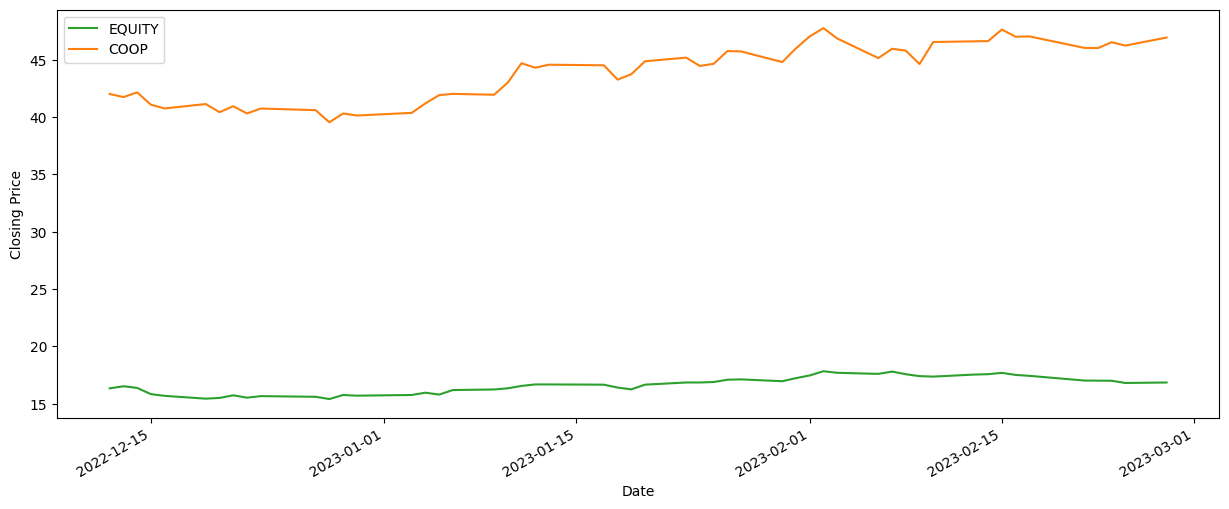

In [58]:
#Plot the closing price of Equity and Cooperative Bank. Label your axes and include a legend

fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_suzlon` and `df_ambuja`
df_equity["close"].plot(ax=ax, label= "EQUITY", color="C2")
df_coop["close"].plot(ax=ax, label= "COOP", color="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")



# Add legend
plt.legend();



In [59]:
#Add a "return" column to df_equity that shows the percentage change in the "close" column from one day to the next.

# Sort DataFrame ascending by date
df_equity.sort_index(ascending=True, inplace=True)

# Create "return" column
df_equity["return"]=df_equity["close"].pct_change() * 100

print("df_equity shape:", df_equity.shape)
print(df_equity.info())
df_equity.head()

df_equity shape: (52, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2022-12-12 to 2023-02-27
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    52 non-null     float64
 1   high    52 non-null     float64
 2   low     52 non-null     float64
 3   close   52 non-null     float64
 4   volume  52 non-null     float64
 5   return  51 non-null     float64
dtypes: float64(6)
memory usage: 2.8 KB
None


,open,high,low,close,volume,return
date,,,,,,
2022-12-12,16.2200,16.3389,16.2200,16.3389,201.0,NaN
2022-12-13,16.5500,16.6600,16.4628,16.5200,103009.0,1.108398
2022-12-14,16.2300,16.5500,16.2300,16.3763,42287.0,-0.869855
2022-12-15,15.9177,16.0000,15.7500,15.8330,48542.0,-3.317599
2022-12-16,15.6500,15.7000,15.5600,15.6839,45241.0,-0.941704


In [60]:
#Add a "return" column to df_coop that shows the percentage change in the "close" column from one day to the next.


# Sort DataFrame ascending by date
df_coop.sort_index(ascending=True, inplace=True)

# Create "return" column
df_coop["return"]=df_coop["close"].pct_change() * 100

print("df_coop shape:", df_coop.shape)
print(df_coop.info())
df_coop.head()

df_coop shape: (52, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2022-12-12 to 2023-02-27
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    52 non-null     float64
 1   high    52 non-null     float64
 2   low     52 non-null     float64
 3   close   52 non-null     float64
 4   volume  52 non-null     float64
 5   return  51 non-null     float64
dtypes: float64(6)
memory usage: 2.8 KB
None


,open,high,low,close,volume,return
date,,,,,,
2022-12-12,42.28,42.4400,41.69,42.01,316522.0,NaN
2022-12-13,43.31,43.9400,41.61,41.74,733461.0,-0.642704
2022-12-14,41.92,42.5600,41.63,42.15,503608.0,0.982271
2022-12-15,41.50,41.6300,40.69,41.07,639939.0,-2.562278
2022-12-16,40.43,41.1273,40.02,40.75,3205243.0,-0.779158


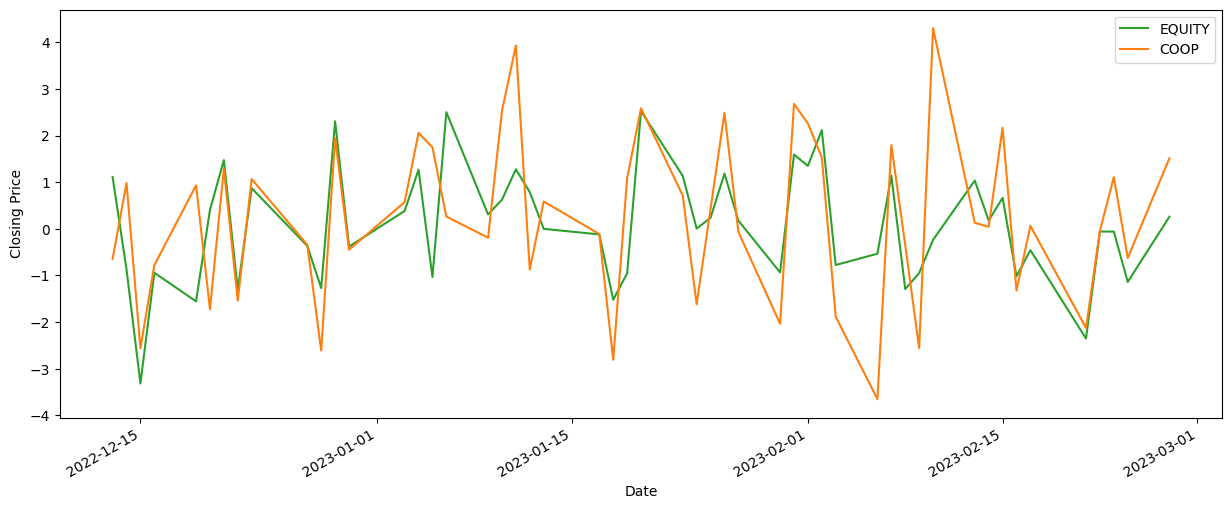

In [61]:
#Plot the returns for df_equity and df_coop. Be sure to label your axes and use legend

fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_equity` and `df_coop`
df_equity["return"].plot(ax=ax, label= "EQUITY", color="C2")
df_coop["return"].plot(ax=ax, label= "COOP", color="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")



# Add legend
plt.legend();


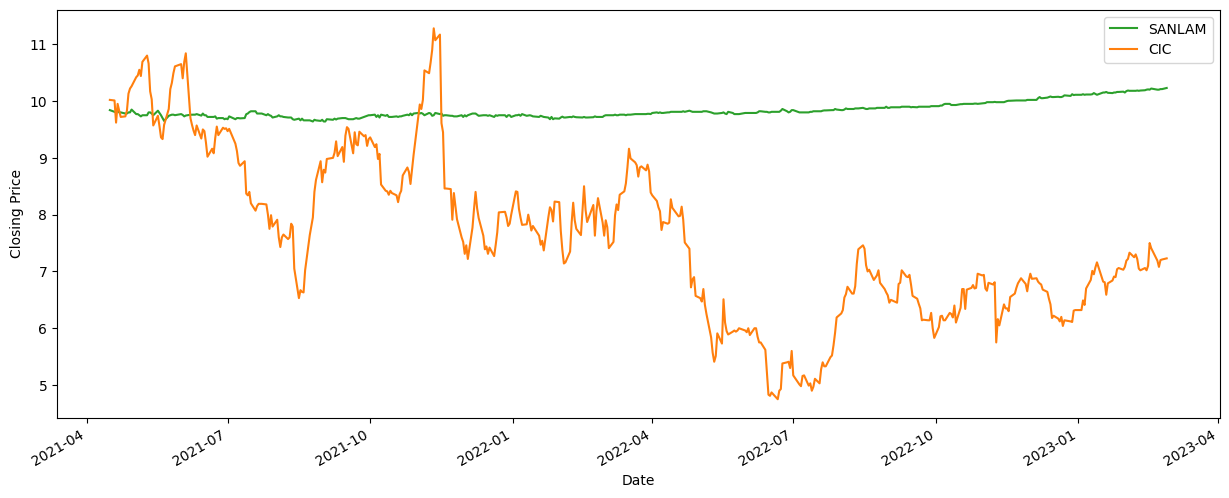

In [67]:
#Plot the closing price of Sanlam and CIC. Label your axes and include a legend


fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_slam` and `df_cic`
df_slam["close"].plot(ax=ax, label= "SANLAM", color="C2")
df_cic["close"].plot(ax=ax, label= "CIC", color="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")



# Add legend
plt.legend();



In [68]:
##Add a "return" column to df_slam that shows the percentage change in the "close" column from one day to the next.


# Sort DataFrame ascending by date
df_slam.sort_index(ascending=True, inplace=True)

# Create "return" column
df_slam["return"]=df_slam["close"].pct_change() * 100

print("df_slam shape:", df_slam.shape)
print(df_slam.info())
df_slam.head()

df_slam shape: (470, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2021-04-16 to 2023-02-27
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    470 non-null    float64
 1   high    470 non-null    float64
 2   low     470 non-null    float64
 3   close   470 non-null    float64
 4   volume  470 non-null    float64
 5   return  469 non-null    float64
dtypes: float64(6)
memory usage: 25.7 KB
None


,open,high,low,close,volume,return
date,,,,,,
2021-04-16,9.8600,9.9299,9.81,9.84,12903.0,NaN
2021-04-19,9.8400,9.9899,9.35,9.81,42138.0,-0.304878
2021-04-20,9.8100,9.9200,9.54,9.80,210036.0,-0.101937
2021-04-21,9.8000,9.8400,9.78,9.84,21055.0,0.408163
2021-04-22,9.8208,9.8900,9.78,9.80,40264.0,-0.406504


In [69]:
###Add a "return" column to df_cic that shows the percentage change in the "close" column from one day to the next.


# Sort DataFrame ascending by date
df_cic.sort_index(ascending=True, inplace=True)

# Create "return" column
df_cic["return"]=df_cic["close"].pct_change() * 100

print("df_cic shape:", df_cic.shape)
print(df_cic.info())
df_cic.head()

df_cic shape: (470, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2021-04-16 to 2023-02-27
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    470 non-null    float64
 1   high    470 non-null    float64
 2   low     470 non-null    float64
 3   close   470 non-null    float64
 4   volume  470 non-null    float64
 5   return  469 non-null    float64
dtypes: float64(6)
memory usage: 25.7 KB
None


,open,high,low,close,volume,return
date,,,,,,
2021-04-16,9.95,10.30,9.71,10.02,195006.0,NaN
2021-04-19,9.96,10.07,9.50,10.01,110815.0,-0.099800
2021-04-20,10.23,10.23,9.55,9.62,139133.0,-3.896104
2021-04-21,9.62,10.03,9.50,9.95,101127.0,3.430353
2021-04-22,9.98,10.15,9.77,9.83,132050.0,-1.206030


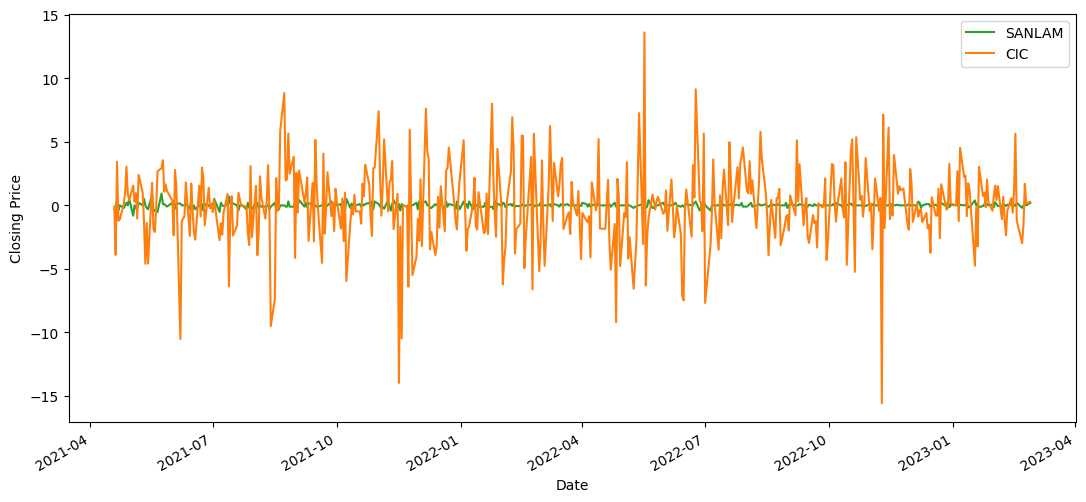

In [71]:
#Plot the returns for df_slam and df_cic. Be sure to label your axes and use legend


fig, ax = plt.subplots(figsize=(13, 6))
# Plot `df_suzlon` and `df_ambuja`
df_slam["return"].plot(ax=ax, label= "SANLAM", color="C2")
df_cic["return"].plot(ax=ax, label= "CIC", color="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")



# Add legend
plt.legend();